# NER using Data Programming


Project Mars Target Encyclopedia


This notebook does not explain much, however, the exaplanations are found in the original notebook(s) https://github.com/HazyResearch/snorkel/tree/master/tutorials/intro 


## Setup:
1. Follow instructions in https://github.com/HazyResearch/snorkel
2. Start jupyter notebook server using `./run.sh` as described in snorkel README
3. copy this notebook to a place accessible from the jupyter server started in previous step. Perhaps you may symlink your directory


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
import os
import numpy as np
import re, string
import codecs

In [3]:
# Open Session
session = SnorkelSession()

## Load all data to snorkel db

In [ ]:

parent = "/Users/thammegr/work/mte/data/newcorpus/workspace"
# these lists are as per our previous experiments
traing_list_file = parent + "/train_62r15_685k14_384k15.list"

dev_list_file = parent + "/development.list"
test_list_file = parent + "/test.list"
# combine all the above using 
# cat train_62r15_685k14_384k15.list development.list test.list > all.list

all_list_file = parent + "/all.list"

# FIXME: overwriting training split, only 70 docs are chosen here
traing_list_file = parent + "/train_head70.list"
# and all list also overriden here
all_list_file = parent + "/all-small.list"

In [ ]:
from snorkel.parser import CSVPathsPreprocessor
from snorkel.parser import TextDocPreprocessor

class CustomTextDocPreprocessor(TextDocPreprocessor):
    """
    It customizes the following: 
        generates custom doc_id which includes parent directory name
                     because the file names are not unique
        Injects file path into the metadata - required for later stage
    """
    def parse_file(self, fp, file_name):
        res = list(super(CustomTextDocPreprocessor, self).parse_file(fp, file_name))
        assert len(res) == 1 # parent class must produce one record per file
        doc, content = res[0]
        doc.name = "/".join(fp.split("/")[-2:]).rsplit('.', 1)[0]
        doc.stable_id = self.get_stable_id(doc.name)
        print(doc.stable_id)
        doc.meta['file_path'] = fp
        yield doc, content

doc_preprocessor = CSVPathsPreprocessor(path=all_list_file, column=0, delim=',',
                                        parser_factory=CustomTextDocPreprocessor)

# Corpus parser to get features
from snorkel.parser import CorpusParser
corpus_parser = CorpusParser()
%time corpus_parser.apply(doc_preprocessor)

In [5]:
from snorkel.models import Document, Sentence

print "Documents:", session.query(Document).count()
print "Sentences:", session.query(Sentence).count()

Documents: 125
Sentences: 8414


In [6]:
# Schema for Minerals
from snorkel.models import candidate_subclass
Mineral = candidate_subclass('Mineral', ['name'])
Target = candidate_subclass('Target', ['name'])
Element = candidate_subclass('Element', ['name'])

In [7]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import RegexMatchEach

name_matcher = RegexMatchEach(attrib='pos_tags', rgx="NN.*")

#Elements and Minerals are unigrams
element_cand_extr = CandidateExtractor(Element, [Ngrams(n_max=1)],[name_matcher])
mineral_cand_extr = CandidateExtractor(Mineral, [Ngrams(n_max=1)],[name_matcher])
# Target names can be unto 4 gram longer
target_cand_extr = CandidateExtractor(Target, [Ngrams(n_max=4)],[name_matcher])

In [8]:
# Counts number of nouns in a sentence => could be used for filtering
def number_of_nouns(sentence):
    active_sequence = False
    count = 0
    last_tag = ''
    for tag in sentence.pos_tags:
        if tag.startswith('NN') and not active_sequence:
            active_sequence = True
            count += 1
        elif not tag.startswith('NN') and active_sequence:
            active_sequence = False
    return count

## Split the corpus into train, development and testing

Here we use the same split we used for previous setup with CoreNLP CRF classifier

In [9]:
def load_paths(fp):
    with open(fp) as fp:
        return set(map(lambda x: x.strip().split(',')[0], fp.readlines()))

train_files = load_paths(traing_list_file)
dev_files = load_paths(dev_list_file)
test_files = load_paths(test_list_file)
splits = [train_files, dev_files, test_files]
print("Docs:: Training size:", len(train_files), 
      "Dev Size:", len(dev_files),
      "Test Size", len(test_files))

from snorkel.models import Document
docs = session.query(Document).order_by(Document.name).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    fp = doc.meta['file_path']
    group_name = []
    for j, split in enumerate(splits):
        group_name.append('1' if fp in split else '0')
    group_name = ''.join(group_name)
    
    if group_name == '000':
        raise Exception("Document %s is not part of any split" % doc.name )
    elif group_name == '100':
        group = train_sents
    elif group_name == '010':
        group = dev_sents
    elif group_name == '001':
        group = test_sents
    else:
        raise Exception("Document %s is in multiple splits %s" % (doc.name, group_name))

    for s in doc.sentences:
        if number_of_nouns(s) > 0: # atleast one name in sentence
            group.add(s)

print("Sentence:: Training size:", len(train_sents), 
      "Dev Size:", len(dev_sents),
      "Test Size", len(test_sents))

('Docs:: Training size:', 70, 'Dev Size:', 20, 'Test Size', 35)
('Sentence:: Training size:', 4460, 'Dev Size:', 1310, 'Test Size', 2392)


### Extract candidates 

Here recall should be high, precison can be bad



NOTE: Dont run this second time... Use the next cell to resume

In [10]:
dataset = train_sents
element_cand_extr.apply(dataset, split=0, clear=True)
mineral_cand_extr.apply(dataset, split=0, clear=False)
target_cand_extr.apply(dataset, split=0, clear=False)

Clearing existing...
Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%



In [11]:
train_elements = session.query(Element).filter(Element.split == 0).all()
print "Number of candidate elements:", len(train_elements)

train_minerals = session.query(Mineral).filter(Mineral.split == 0).all()
print "Number of candidate Minerals:", len(train_minerals)

train_targets = session.query(Target).filter(Target.split == 0).all()
print "Number of candidate targets:", len(train_targets)

Number of candidate elements: 36933
Number of candidate Minerals: 36933
Number of candidate targets: 26887


## Extract Develop and Test Sets 



NOTE: DO not run this second time... 

In [12]:
for i, sents in enumerate([dev_sents, test_sents]):
    element_cand_extr.apply(sents, split=i+1, clear=True)
    mineral_cand_extr.apply(sents, split=i+1, clear=False)
    target_cand_extr.apply(sents, split=i+1, clear=False)
    print "Number of Elements:", session.query(Element).filter(Element.split == i+1).count()
    print "Number of Minerals:", session.query(Mineral).filter(Mineral.split == i+1).count()
    print "Number of Targets:", session.query(Target).filter(Target.split == i+1).count()

Clearing existing...
Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

Number of Elements: 11151
Number of Minerals: 11151
Number of Targets: 8051
Clearing existing...
Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

Running UDF...
[========================================] 100%

Number of Elements: 19443
Number of Minerals: 19443
Number of Targets: 13871


## Labelling Functions

### Targets
#### 1.  From a known dictionary

In [13]:

def load_set(path, lower=True):
    with codecs.open(path, 'r', 'utf-8') as f:
        lines = f.readlines()
        lines = map(lambda x: x.strip(), lines)
        lines = filter(lambda x: x and not x.startswith('#'), lines)
        if lower:
            lines = map(lambda x: x.lower(), lines)
        return set(lines)

mte_targets = load_set("/Users/thammegr/work/mte/git/ref/MER-targets-pruned.txt", lower=False)
print("Found %d target names in MTE dictionary" % len(mte_targets))

mte_targets = set(map(lambda x: x.replace('_', ' ').title(), mte_targets))

##
def LF_mte_targets_dict(c):
     return 1 if c.name.get_span().title() in mte_targets else -1

Found 2137 target names in MTE dictionary


#### 2. From wikipedia page

In [14]:
from lxml import etree
# lxml supports XPath 1.0 which doesn't've regex match, so extending it
ns = etree.FunctionNamespace(None)
ns['matches'] = lambda _, val, patrn: re.match(patrn, str(val[0]) if val else "") is not None

In [17]:
import requests
mars_rocks_page = "https://en.wikipedia.org/wiki/List_of_rocks_on_Mars"
tree = etree.HTML(requests.get(mars_rocks_page).text)
names = tree.xpath('//h2[matches(span/@id, "^[0-9]{4}_.*")]/following-sibling::div[2]/ul/li//text()')

names = map(lambda x: re.sub("\(.*\)", "", x), names)  # remove explainations in ()
names = map(lambda x: re.sub(r'[^\w\s]','', x), names) # remove punctuations
names = map(lambda x: x.strip(), names)     # remove whitespaces
names = filter(lambda x: re.match("^\d+$", x) is None, names) # remove the number citations which were [num] originally
names = filter(lambda x: x and x[0].isupper(), names)   # name should start with capital letter
names = map(lambda x: x.title(), names)     # map to title case
wikipedia_targets = set(names)
print("Found %d target names on wikipedia %s" %(len(wikipedia_targets), mars_rocks_page))

Found 384 target names on wikipedia https://en.wikipedia.org/wiki/List_of_rocks_on_Mars


In [18]:
def LF_wikip_targets_dict(c):
     return 1 if c.name.get_span().title() in wikipedia_targets else 0
     # this list is not exhaustive, so return 0 for missing

In [19]:
# Debugging label functions
from pprint import pprint

labeled = []
for c in session.query(Target).filter(Target.split == 0).all():
    if LF_wikip_targets_dict(c) != 0: # function 
        labeled.append(c)

print "Number labeled:", len(labeled)

Number labeled: 298


In [20]:
# Sample labeled
labeled[:10]

[Target(Span("Confidence Hills", sentence=3762, chars=[69,84], words=[13,14])),
 Target(Span("Chinle", sentence=1533, chars=[35,40], words=[5,5])),
 Target(Span("Cumberland", sentence=2553, chars=[0,9], words=[0,0])),
 Target(Span("Cumberland", sentence=2553, chars=[22,31], words=[6,6])),
 Target(Span("Windjana", sentence=1421, chars=[96,103], words=[15,15])),
 Target(Span("Confidence Hills", sentence=1695, chars=[84,99], words=[14,15])),
 Target(Span("Chinle", sentence=1695, chars=[106,111], words=[17,17])),
 Target(Span("Darwin outcrop", sentence=2087, chars=[38,51], words=[6,7])),
 Target(Span("Book Cliffs", sentence=1699, chars=[53,63], words=[10,11])),
 Target(Span("Winnipesaukee", sentence=183, chars=[0,12], words=[0,0]))]

In [21]:
LFs = [
    LF_mte_targets_dict,
    LF_wikip_targets_dict
]

print("We have %d labeling functions" % len(LFs))

We have 2 labeling functions


In [22]:
from snorkel.annotations import LabelAnnotator
import numpy as np
labeler = LabelAnnotator(f=LFs)

In [23]:
#Let us label the training set
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 6min 22s, sys: 971 ms, total: 6min 23s
Wall time: 6min 24s


<100753x2 sparse matrix of type '<type 'numpy.float64'>'
	with 101613 stored elements in Compressed Sparse Row format>

In [24]:
# Loading it again  -- resume from here
L_train = labeler.load_matrix(session, split=0)
L_train

<100753x2 sparse matrix of type '<type 'numpy.float64'>'
	with 101613 stored elements in Compressed Sparse Row format>

In [27]:
L_train.get_candidate(session, 10)

Element(Span("function", sentence=1175, chars=[39,46], words=[7,7]))

In [31]:
# Get stats of LFs
L_train.lf_stats(session, )

,j,Coverage,Overlaps,Conflicts
LF_mte_targets_dict,0,1.000000,0.008536,0.007891
LF_wikip_targets_dict,1,0.008536,0.008536,0.007891


## Generative model 

In [32]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=500, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=1e-6)

/Users/thammegr/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


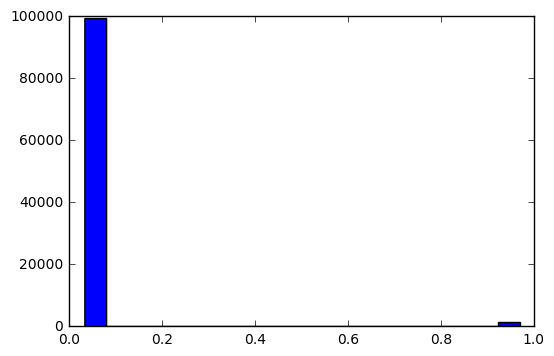

In [33]:
train_marginals = gen_model.marginals(L_train)
# visualize 
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [34]:
gen_model.weights.lf_accuracy()

array([ 0.84098206,  0.51640136])

In [35]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [36]:
L_dev

<30353x2 sparse matrix of type '<type 'numpy.float64'>'
	with 30558 stored elements in Compressed Sparse Row format>

In [44]:
# development split
dev_cands = session.query(Target).filter(Target.split == 1).all()
len(dev_cands)

8051

In [46]:
dev_cands[:10]f

[Target(Span("Table", sentence=5597, chars=[72,76], words=[14,14])),
 Target(Span("sand grains", sentence=5597, chars=[59,69], words=[11,12])),
 Target(Span("medium", sentence=5597, chars=[42,47], words=[8,8])),
 Target(Span("ripples", sentence=5597, chars=[5,11], words=[1,1])),
 Target(Span("ripple crests", sentence=5575, chars=[29,41], words=[5,6])),
 Target(Span("Treiman A.H.", sentence=4788, chars=[4,15], words=[3,4])),
 Target(Span("Venus Technology Workshop", sentence=4788, chars=[38,62], words=[11,13])),
 Target(Span("Abstr", sentence=4788, chars=[65,69], words=[15,15])),
 Target(Span("Dyar M.D.", sentence=4788, chars=[21,29], words=[6,7])),
 Target(Span("ChemCam", sentence=4889, chars=[58,64], words=[9,9]))]

In [47]:
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(dev_cands, session)
sv

<IPython.core.display.Javascript object>

In [102]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name=os.environ['USER'], split=1)
L_gold_dev


<30353x1 sparse matrix of type '<type 'numpy.float64'>'
	with 55 stored elements in Compressed Sparse Row format>

In [49]:
type(L_gold_dev)

snorkel.annotations.csr_LabelMatrix

In [101]:
from snorkel.annotations import (csr_LabelMatrix, load_matrix, GoldLabelKey, GoldLabel)
from snorkel.models import StableLabel
from snorkel.db_helpers import reload_annotator_labels

# NOTE: this is a shortcut for labeling 
# Ideally we should use labels from the SentenceNgramViewer 

true_labeller = LF_mte_targets_dict

def load_gold_labels(cand_set, candidate_class, annotator_name="gold"):
    count = 0
    for cand in cand_set:
        ctx_stable_ids = cand.name.get_span()
        query = session.query(StableLabel).filter(StableLabel.context_stable_ids == ctx_stable_ids)
        query = query.filter(StableLabel.annotator_name == annotator_name)
        
        if query.count() == 0:
            count += 1
            true_label = true_labeller(cand)            
            session.add(StableLabel(
                context_stable_ids=ctx_stable_ids,
                annotator_name=annotator_name,
                value=true_label))

    # Commit session
    session.commit()

    # Reload annotator labels
    reload_annotator_labels(session, candidate_class, annotator_name, split=1, filter_label_split=False)
    reload_annotator_labels(session, candidate_class, annotator_name, split=2, filter_label_split=False)
load_gold_labels(dev_cands, Target)

AnnotatorLabels created: 0
AnnotatorLabels created: 0


In [ ]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
tot = L_gold_dev.shape[0]
n = len(filter(lambda x: x == 1, L_gold_dev))
print("Found %d positive labels out of %d" % (n, tot))

In [84]:
tp, fp, tn, fn = gen_model.score(session, L_dev, L_gold_dev)

AttributeError: get_row_index not found

In [89]:
dev_cands[0].name.get_span()

u'Table'